# Machine Learning Model for Dublin Bikes application

In [722]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression ## maybe logisitic regression??????

# Clean and standardize the data

In [723]:
# we just need to create a collect csv files for both and put them in here
df_bike = pd.read_csv('dynamic_4_4_23.csv')
df_bike.head()

,number,name,bike_stands,available_bike_stands,available_bikes,status,s_date,s_time
0,42,SMITHFIELD NORTH,30,15,15,OPEN,2023-03-03,10:47:16
1,30,PARNELL SQUARE NORTH,20,19,1,OPEN,2023-03-03,10:45:35
2,54,CLONMEL STREET,33,21,12,OPEN,2023-03-03,10:49:41
3,108,AVONDALE ROAD,35,17,18,OPEN,2023-03-03,10:44:37
4,20,JAMES STREET EAST,30,12,17,OPEN,2023-03-03,10:44:23


In [724]:
df_weather= pd.read_csv('weather_4_4_23.csv')
df_weather.head()

,latitude,longitude,weather_id,weather_main,weather_description,weather_icon,temperature,feels_like,pressure,humidity,visibility,wind_speed,wind_direction,rain,snow,clouds,sunrise,sunset,w_date,w_time
0,53.3498,-6.2603,803,Clouds,broken clouds,04n,277.88,275.58,1033,82,10000,2.68,20,0.0,0.0,75,1677913611,1677953230,2023-03-04,00:00:00
1,53.3498,-6.2603,803,Clouds,broken clouds,04n,278.49,276.00,1032,78,10000,3.09,10,0.0,0.0,75,1677913611,1677953230,2023-03-04,01:00:00
2,53.3498,-6.2603,803,Clouds,broken clouds,04n,278.44,275.94,1032,79,10000,3.09,340,0.0,0.0,75,1677913611,1677953230,2023-03-04,02:00:00
3,53.3498,-6.2603,803,Clouds,broken clouds,04n,278.44,276.80,1032,77,10000,2.06,330,0.0,0.0,75,1677913611,1677953230,2023-03-04,03:00:00
4,53.3498,-6.2603,803,Clouds,broken clouds,04n,278.00,276.11,1032,78,10000,2.24,320,0.0,0.0,75,1677913611,1677953230,2023-03-04,04:00:00


### Drop 3rd March Data and any data after the 31st March

In [725]:
df_bike['s_date'] = pd.to_datetime(df_bike['s_date'])
drop_dates=df_bike[df_bike['s_date'] >= '2023-03-04']
drop_dates.head()

,number,name,bike_stands,available_bike_stands,available_bikes,status,s_date,s_time
18059,20,JAMES STREET EAST,30,24,6,OPEN,2023-03-04,00:00:01
18060,56,MOUNT STREET LOWER,40,31,9,OPEN,2023-03-04,00:00:34
18061,6,CHRISTCHURCH PLACE,20,20,0,OPEN,2023-03-04,00:00:25
18083,114,WILTON TERRACE (PARK),40,40,0,OPEN,2023-03-04,00:00:22
18086,113,MERRION SQUARE SOUTH,40,39,1,OPEN,2023-03-04,00:00:26


In [726]:
drop_dates = drop_dates[drop_dates['s_date'].dt.month != 4]
drop_dates.tail()

,number,name,bike_stands,available_bike_stands,available_bikes,status,s_date,s_time
935841,44,UPPER SHERRARD STREET,30,7,23,OPEN,2023-03-31,23:57:32
935842,89,FITZWILLIAM SQUARE EAST,40,32,8,OPEN,2023-03-31,23:59:04
935855,88,BLACKHALL PLACE,30,20,10,OPEN,2023-03-31,23:56:27
935904,60,NORTH CIRCULAR ROAD,30,0,30,OPEN,2023-03-31,23:59:51
935951,109,BUCKINGHAM STREET LOWER,29,16,13,OPEN,2023-03-31,23:59:49


### Drop weather data for the test week as whole week not collected yet

In [727]:
df_weather['w_date'] = pd.to_datetime(df_weather['w_date'])
drop_w=df_weather[df_weather['w_date'].dt.month != 4]
drop_w.tail()

,latitude,longitude,weather_id,weather_main,weather_description,weather_icon,temperature,feels_like,pressure,humidity,visibility,wind_speed,wind_direction,rain,snow,clouds,sunrise,sunset,w_date,w_time
666,53.3498,-6.2603,501,Rain,moderate rain,10d,284.04,283.56,997,91,6000,5.14,280,1.15,0.0,75,1680242506,1680288995,2023-03-31,19:00:00
667,53.3498,-6.2603,500,Rain,light rain,10n,283.55,283.02,998,91,6000,6.17,300,0.42,0.0,75,1680242506,1680288995,2023-03-31,20:00:00
668,53.3498,-6.2603,501,Rain,moderate rain,10n,283.57,283.04,999,91,7000,3.60,310,1.15,0.0,75,1680242506,1680288995,2023-03-31,21:00:00
669,53.3498,-6.2603,500,Rain,light rain,10n,282.93,280.23,1000,93,7000,5.66,280,0.42,0.0,75,1680242506,1680288995,2023-03-31,22:00:00
670,53.3498,-6.2603,500,Rain,light rain,10n,282.93,280.23,1000,93,10000,5.66,280,0.12,0.0,75,1680242506,1680288995,2023-03-31,23:00:00


### Test data goes from 1st-7th April

In [728]:
##code to get the test data

#### Now seperate drop dates into training and validation data

In [729]:
training_data=drop_dates[drop_dates['s_date']<='2023-03-24']
training_data.tail()

,number,name,bike_stands,available_bike_stands,available_bikes,status,s_date,s_time
707154,85,ROTHE ABBEY,35,22,13,OPEN,2023-03-24,23:59:23
707158,89,FITZWILLIAM SQUARE EAST,40,39,1,OPEN,2023-03-24,23:57:19
707163,40,JERVIS STREET,21,4,17,OPEN,2023-03-24,23:56:56
707165,103,GRANGEGORMAN LOWER (SOUTH),40,39,1,OPEN,2023-03-24,23:58:12
707168,83,EMMET ROAD,40,31,9,OPEN,2023-03-24,23:57:58


In [730]:
training_weather=drop_w[drop_w['w_date']<='2023-03-24']
training_weather.tail()

,latitude,longitude,weather_id,weather_main,weather_description,weather_icon,temperature,feels_like,pressure,humidity,visibility,wind_speed,wind_direction,rain,snow,clouds,sunrise,sunset,w_date,w_time
499,53.3498,-6.2603,500,Rain,light rain,10n,281.70,276.95,987,79,10000,12.35,230,NaN,0.0,20,1679638727,1679683437,2023-03-24,19:00:00
500,53.3498,-6.2603,520,Rain,light intensity shower rain,09n,281.33,277.00,988,83,10000,9.77,230,NaN,0.0,40,1679638727,1679683437,2023-03-24,20:00:00
501,53.3498,-6.2603,500,Rain,light rain,10n,281.83,277.55,989,82,10000,10.29,240,NaN,0.0,75,1679638727,1679683437,2023-03-24,21:00:00
502,53.3498,-6.2603,500,Rain,light rain,10n,281.45,277.04,990,80,10000,10.29,240,NaN,0.0,75,1679638727,1679683437,2023-03-24,22:00:00
503,53.3498,-6.2603,520,Rain,light intensity shower rain,09n,281.45,277.16,992,83,10000,9.77,240,0.0,0.0,75,1679638727,1679683437,2023-03-24,23:00:00


In [731]:
validation_data=drop_dates[drop_dates['s_date']>'2023-03-24']
validation_data.head()

,number,name,bike_stands,available_bike_stands,available_bikes,status,s_date,s_time
706946,54,CLONMEL STREET,33,29,4,OPEN,2023-03-25,00:00:17
706952,32,PEARSE STREET,30,24,6,OPEN,2023-03-25,00:00:27
706960,1,CLARENDON ROW,31,20,11,OPEN,2023-03-25,00:00:30
706961,23,CUSTOM HOUSE,30,3,27,OPEN,2023-03-25,00:00:07
706964,68,HANOVER QUAY,40,31,9,OPEN,2023-03-25,00:00:06


In [732]:
validation_weather=drop_w[drop_w['w_date']>'2023-03-24']
validation_weather.head()

,latitude,longitude,weather_id,weather_main,weather_description,weather_icon,temperature,feels_like,pressure,humidity,visibility,wind_speed,wind_direction,rain,snow,clouds,sunrise,sunset,w_date,w_time
504,53.3498,-6.2603,803,Clouds,broken clouds,04n,281.43,277.52,993,83,10000,8.23,260,0.0,0.0,75,1679724981,1679769946,2023-03-25,00:00:00
505,53.3498,-6.2603,803,Clouds,broken clouds,04n,281.44,277.40,994,84,10000,8.75,240,0.0,0.0,75,1679724981,1679769946,2023-03-25,01:00:00
506,53.3498,-6.2603,520,Rain,light intensity shower rain,09n,280.87,276.65,995,85,10000,8.75,240,NaN,0.0,40,1679724981,1679769946,2023-03-25,02:00:00
507,53.3498,-6.2603,500,Rain,light rain,10n,280.80,276.56,995,85,10000,8.75,240,NaN,0.0,40,1679724981,1679769946,2023-03-25,03:00:00
508,53.3498,-6.2603,500,Rain,light rain,10n,280.45,276.17,996,85,10000,8.49,260,NaN,0.0,40,1679724981,1679769946,2023-03-25,04:00:00


In [733]:
###do the same for test data

### When the code is merged what columns will I keep:
- Name
- Bike_stands, available_bikes and available_bike stands
- s_date- to convert to the correct day
- s_time to convert to the nearest hour
- temperature
- wind_speed
- rain_1 
- weather_main

- Reasoning: I think time of day, extremely high/low temp, extremely high winds and heavy rainfall can predict a variance in bike use

### Maybe clean all the data first and then divide into training/validation/testing

In [772]:
##set this to all the dates on saturday for testing and validation
df_bike=drop_dates
df_weather=drop_w

### What does the following do

In [773]:
df_bike['s_time'] =df_bike['s_time'].astype(str).apply(lambda x: str(x).split(' ')[-1])
df_weather['w_time'] = df_weather['w_time'].astype(str).apply(lambda x: str(x).split(' ')[-1])
df_bike['datetime'] = pd.to_datetime(df_bike['s_date'].astype(str) + ' ' + df_bike['s_time'].astype(str).apply(lambda x: str(x).split(' ')[-1]))
df_weather['datetime'] = pd.to_datetime(df_weather['w_date'].astype(str) + ' ' + df_weather['w_time'].astype(str).apply(lambda x: str(x).split(' ')[-1]))

In [774]:
df_bike = df_bike.sort_values('datetime')
df_weather = df_weather.sort_values('datetime')

df_main = pd.merge_asof(df_bike, df_weather, on='datetime', direction='nearest')
df_main.tail()

,number,name,bike_stands,available_bike_stands,available_bikes,status,s_date,s_time,datetime,latitude,...,visibility,wind_speed,wind_direction,rain,snow,clouds,sunrise,sunset,w_date,w_time
915629,48,EXCISE WALK,40,26,14,OPEN,2023-03-31,23:59:05,2023-03-31 23:59:05,53.3498,...,10000,5.66,280,0.12,0.0,75,1680242506,1680288995,2023-03-31,23:00:00
915630,109,BUCKINGHAM STREET LOWER,29,16,13,OPEN,2023-03-31,23:59:49,2023-03-31 23:59:49,53.3498,...,10000,5.66,280,0.12,0.0,75,1680242506,1680288995,2023-03-31,23:00:00
915631,109,BUCKINGHAM STREET LOWER,29,16,13,OPEN,2023-03-31,23:59:49,2023-03-31 23:59:49,53.3498,...,10000,5.66,280,0.12,0.0,75,1680242506,1680288995,2023-03-31,23:00:00
915632,60,NORTH CIRCULAR ROAD,30,0,30,OPEN,2023-03-31,23:59:51,2023-03-31 23:59:51,53.3498,...,10000,5.66,280,0.12,0.0,75,1680242506,1680288995,2023-03-31,23:00:00
915633,60,NORTH CIRCULAR ROAD,30,0,30,OPEN,2023-03-31,23:59:51,2023-03-31 23:59:51,53.3498,...,10000,5.66,280,0.12,0.0,75,1680242506,1680288995,2023-03-31,23:00:00


# Cleaning the dataframe

In [775]:
df_main.columns

Index(['number', 'name', 'bike_stands', 'available_bike_stands',
       'available_bikes', 'status', 's_date', 's_time', 'datetime', 'latitude',
       'longitude', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon', 'temperature', 'feels_like', 'pressure', 'humidity',
       'visibility', 'wind_speed', 'wind_direction', 'rain', 'snow', 'clouds',
       'sunrise', 'sunset', 'w_date', 'w_time'],
      dtype='object')

In [776]:
df_main = df_main.drop(['name', 'status', 's_date', 's_time','latitude',
       'longitude', 'weather_id', 'weather_main','weather_description',
       'weather_icon', 'feels_like','pressure','humidity', 
       'visibility','wind_direction', 'snow',
       'clouds', 'sunrise', 'sunset',
       'w_date', 'w_time'], axis = 1)

### Getting the available bike stands percentage

In [777]:
df_main["availability_percentage"] = 100*df_main["available_bikes"]/(df_main["bike_stands"])
df_main["availability_percentage"].round(0)

0          20.0
1          20.0
2         100.0
3          25.0
4         100.0
          ...  
915629     35.0
915630     45.0
915631     45.0
915632    100.0
915633    100.0
Name: availability_percentage, Length: 915634, dtype: float64

In [778]:
df_main.columns

Index(['number', 'bike_stands', 'available_bike_stands', 'available_bikes',
       'datetime', 'temperature', 'wind_speed', 'rain',
       'availability_percentage'],
      dtype='object')

In [779]:
df_main["temperature"] = df_main["temperature"] - 275.15

#### Find null values in dataset

In [780]:
### find null values
df_main.isnull().sum()

number                          0
bike_stands                     0
available_bike_stands           0
available_bikes                 0
datetime                        0
temperature                     0
wind_speed                      0
rain                       273695
availability_percentage         0
dtype: int64

In [781]:
### convert null values to zero instead
df_main = df_main.fillna(0)

In [782]:
df_main["datetime"] = pd.to_datetime(df_main["datetime"])
df_main["hour"] = df_main["datetime"].dt.hour#+df_main["datetime"].dt.minute / 60
##round hour to 2 decimal places
df_main["hour"] = df_main["hour"].round(2)
df_main["day_of_week"] = df_main["datetime"].dt.strftime('%A')

# One-hot encoding for categorical

In [783]:
one_hot = pd.get_dummies(df_main["day_of_week"])
df_main = pd.concat([df_main, one_hot], axis = 1)

In [792]:
df_main.tail()

,number,bike_stands,available_bike_stands,available_bikes,temperature,wind_speed,rain,availability_percentage,hour,day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
915629,48,40,26,14,7.78,5.66,0.12,35.000000,23,Friday,0,0,0,0,1,0,0
915630,109,29,16,13,7.78,5.66,0.12,44.827586,23,Friday,0,0,0,0,1,0,0
915631,109,29,16,13,7.78,5.66,0.12,44.827586,23,Friday,0,0,0,0,1,0,0
915632,60,30,0,30,7.78,5.66,0.12,100.000000,23,Friday,0,0,0,0,1,0,0
915633,60,30,0,30,7.78,5.66,0.12,100.000000,23,Friday,0,0,0,0,1,0,0


In [785]:
###drop day of week
#df_main = df_main.drop(['day_of_week'], axis = 1)
## and date time
df_main = df_main.drop(['datetime'], axis = 1)

In [786]:
## order the columns from Monday to Sunday
df_main = df_main[['number','bike_stands','available_bike_stands','available_bikes', 'temperature', 'wind_speed','rain', 'availability_percentage','hour','day_of_week', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', "Saturday", 'Sunday']]

### converting to int

In [787]:
for column in df_main.columns:
    if df_main[column].dtype == "uint8":
        df_main[column] = df_main[column].astype("int64")

In [788]:
df_main.dtypes

number                       int64
bike_stands                  int64
available_bike_stands        int64
available_bikes              int64
temperature                float64
wind_speed                 float64
rain                       float64
availability_percentage    float64
hour                         int64
day_of_week                 object
Monday                       int64
Tuesday                      int64
Wednesday                    int64
Thursday                     int64
Friday                       int64
Saturday                     int64
Sunday                       int64
dtype: object

In [789]:
df_train=df_main.copy()
df_train.drop(['day_of_week'], axis = 1, inplace=True)

X = df_train.drop(['availability_percentage'], axis = 1)
y = df_train['availability_percentage']

print("\nDescriptive features in X:\n", X)
print("\nTarget feature in y:\n", y)




Descriptive features in X:
         number  bike_stands  available_bike_stands  available_bikes  \
0           20           30                     24                6   
1           20           30                     24                6   
2           93           40                      0               40   
3           67           40                     30               10   
4           93           40                      0               40   
...        ...          ...                    ...              ...   
915629      48           40                     26               14   
915630     109           29                     16               13   
915631     109           29                     16               13   
915632      60           30                      0               30   
915633      60           30                      0               30   

        temperature  wind_speed  rain  hour  Monday  Tuesday  Wednesday  \
0              2.73        2.68  0.00     0

In [790]:
linreg = LinearRegression().fit(X, y)
print("Coeficients: \n", linreg.coef_)
print("\nIntercept: \n", linreg.intercept_)


linreg_predictions = linreg.predict(X)

print("\nPredictions with linear regression: \n")
actual_vs_predicted_linreg = pd.concat([y, pd.DataFrame(linreg_predictions, columns=['Predicted'], index=y.index)], axis=1)
print(actual_vs_predicted_linreg)



Coeficients: 
 [ 2.35947279e-03 -1.39778616e+00  2.26859279e-01  3.24489194e+00
 -7.25891387e-03 -4.69466356e-02 -5.89374621e-02  1.01358891e-02
 -4.41982818e-01 -1.10505493e+00 -5.20107798e-01  6.14070927e-02
  5.20341173e-01  5.84152637e-01  9.01244639e-01]

Intercept: 
 39.42713872014963

Predictions with linear regression: 

        availability_percentage   Predicted
0                     20.000000   22.893236
1                     20.000000   22.893236
2                    100.000000  113.969320
3                     25.000000   23.366994
4                    100.000000  113.969320
...                         ...         ...
915629                35.000000   35.379977
915630                44.827586   45.386068
915631                44.827586   45.386068
915632               100.000000   95.406082
915633               100.000000   95.406082

[915634 rows x 2 columns]


In [791]:


#This function is used repeatedly to compute all metrics
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    #print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))
        



printMetrics(y, linreg_predictions)




MAE:  4.951330081901145
RMSE:  6.795891528452855
R2:  0.9458029865833777


In [793]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [795]:
# Train on the training sample and test on the test sample.
linreg = LinearRegression().fit(X_train, y_train)
train_predictions = linreg.predict(X_train)
print("Actual vs predicted on training:\n", pd.concat([y_train, pd.DataFrame(train_predictions, columns=['Predicted'], index=y_train.index)], axis=1))
printMetrics(y_train, train_predictions)

Actual vs predicted on training:
         availability_percentage  Predicted
747324                17.500000  14.902896
407074                69.565217  60.616768
51081                  4.000000  14.084890
45739                 12.500000   8.520997
290611                76.666667  74.428391
...                         ...        ...
882371                 5.000000  -1.310129
152315                82.608696  69.174734
117952                46.666667  45.493887
435829                37.500000  38.419479
305711                26.666667  27.603739

[640943 rows x 2 columns]

MAE:  4.953132096852066
RMSE:  6.797533544681657
R2:  0.9457332902256336


In [796]:
test_predictions = linreg.predict(X_test)
print("Actual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1))
printMetrics(y_test, test_predictions)

Actual vs predicted on test:
         availability_percentage  Predicted
71800                  0.000000   7.319914
773676                42.500000  43.492309
897678                 7.500000   2.311135
473759                20.000000  17.238159
197894                 0.000000   4.329426
...                         ...        ...
719048                 2.857143   2.342833
40397                100.000000  95.839080
853491                25.000000  31.700020
688131                23.333333  25.814350
338889                30.000000  32.880011

[274691 rows x 2 columns]

MAE:  4.952220920783138
RMSE:  6.792143206061546
R2:  0.9459637092206878


### Divide data into training/validation and testing
- Drop all data for the 3rd March
- Train- first 3 weeks, Validation next 1 week. Test 1 week
- Starting at Saturday 00:00AM
- Dates Training 4/3/23 to end of 24/3/23
- Dates validation 25/3/23 to end of 31st
- Dates training 1/4/23 to end of 7/4th/23


In [798]:
from sklearn.model_selection import train_test_split

def divide_data(station_number, dataframe):
    df_div = dataframe[dataframe["number"] == station_number].copy()

    # Split the data into train and test sets
    ## i disagree here, we should split the data into train, test and validation sets
    
    train = df_div.drop(labels=['number', 'bike_stands', 'available_bike_stands'], axis=1)


    # Split the train and test sets into x and y
    x_train = train.drop("availability_percentage", axis=1)
    y_train = train["availability_percentage"]

    return df_div, x_train, y_train


# Check the relation between x columns and y column

if you find some unrelated input columns from the scatter below, you can drop it

In [799]:
def check_xy(x, y):
    for column in x.columns:
        plt.scatter(x[column], y)
        plt.title(column)
        plt.ylabel("Bike Availability %")
        plt.xlabel(column)
        plt.show()

# Training the model

In [800]:
def training_model(train_x, train_y):
    reg = LinearRegression()
    reg.fit(train_x, train_y)
    print(f"train score : {reg.score(train_x, train_y)}")
    return reg

# Save the model into a folder

In [801]:
import pickle


def save_model(model, stationnumber):
    filename = f'/home/cian/Documents/GitHub/dublinbikes/datamodel/models/model_{stationnumber}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Execute the models with for loop

In [802]:
df_main.head()
df_pickle=df_main.copy()
df_pickle.drop('day_of_week', axis=1, inplace=True)

In [803]:
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))

In [804]:
for station_number in df_pickle["number"].unique():
    df_station, x_train, y_train = divide_data(station_number, df_pickle)
    #print(x_train)
    #print(y_train)
    #model = training_model(x_train, y_train)
    #This function is used repeatedly to compute all metrics
    linreg = LinearRegression().fit(X, y)

    linreg_predictions = linreg.predict(X)
        
    printMetrics(y_train, linreg_predictions)
    
    #save_model(model, station_number)

ValueError: Found input variables with inconsistent numbers of samples: [8033, 915634]

### Plot the data

In [758]:
# filter the DataFrame to only include rows where 'Monday' equals 1
df_mondays = df_main[df_main['Monday'] == 1]
#pick one station
df_mondays = df_mondays[df_mondays['number'] == 93]
df_mondays.head()

,number,bike_stands,available_bike_stands,available_bikes,temperature,wind_speed,rain,availability_percentage,hour,day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
65443,93,40,7,33,4.02,5.81,0.0,82.5,0,Monday,1,0,0,0,0,0,0
65444,93,40,7,33,4.02,5.81,0.0,82.5,0,Monday,1,0,0,0,0,0,0
65681,93,40,7,33,4.02,5.81,0.0,82.5,0,Monday,1,0,0,0,0,0,0
65682,93,40,7,33,4.02,5.81,0.0,82.5,0,Monday,1,0,0,0,0,0,0
65908,93,40,7,33,4.02,5.81,0.0,82.5,0,Monday,1,0,0,0,0,0,0


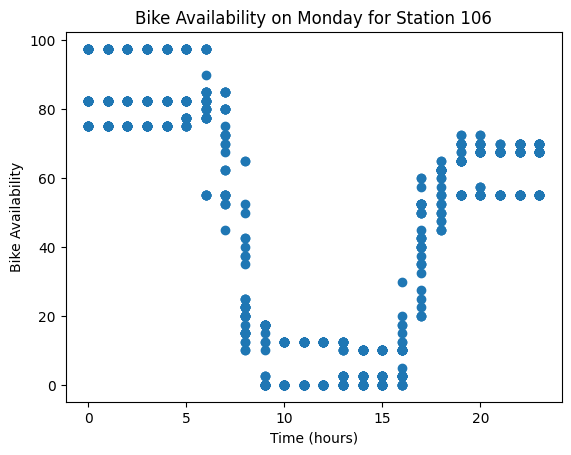

In [759]:
# create scatter plot using the filtered DataFrame
plt.scatter(df_mondays['hour'], df_mondays['availability_percentage'])
plt.title("Bike Availability on Monday for Station 106")
plt.ylabel("Bike Availability")
plt.xlabel("Time (hours)")
plt.show()


In [760]:

def average_bike_availability(numb):
    # filter the DataFrame to only include data for one station
    df_station = df_main.loc[df_main['number'] == numb].copy()
    # set the order of days of the week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # create a new column to map the days of the week to a numerical order
    df_station['day_of_week_order'] = pd.Categorical(df_station['day_of_week'], categories=day_order, ordered=True)
    df_station = df_station.sort_values('day_of_week_order')


    # calculate the mean availability percentage for each hour of the day and day of the week
    df_hourly = df_station.groupby(['day_of_week_order','hour'])['availability_percentage'].mean()
    df_hourly.dropna(inplace=True)

    # plot a line plot of the data
    df_hourly.plot(kind='line', figsize=(10,8))

    plt.title(f"Average Bike Availability for Station {numb} over the Week")
    plt.xlabel("Day of the Week")
    plt.ylabel("Bike Availability")
    plt.ylim(0, 100)
    plt.show()


### Import static bike numbers


In [761]:
# we just need to create a collect csv files for both and put them in here
df_static = pd.read_csv('static_30_3_23.csv')
df_static.head()

,number,contract_name,name,address,position_lat,position_lng,banking,bonus
0,42,dublin,SMITHFIELD NORTH,Smithfield North,53.349562,-6.278198,0,0
1,30,dublin,PARNELL SQUARE NORTH,Parnell Square North,53.353742,-6.265301,0,0
2,54,dublin,CLONMEL STREET,Clonmel Street,53.336021,-6.262980,0,0
3,108,dublin,AVONDALE ROAD,Avondale Road,53.359405,-6.276142,0,0
4,20,dublin,JAMES STREET EAST,James Street East,53.336597,-6.248109,0,0


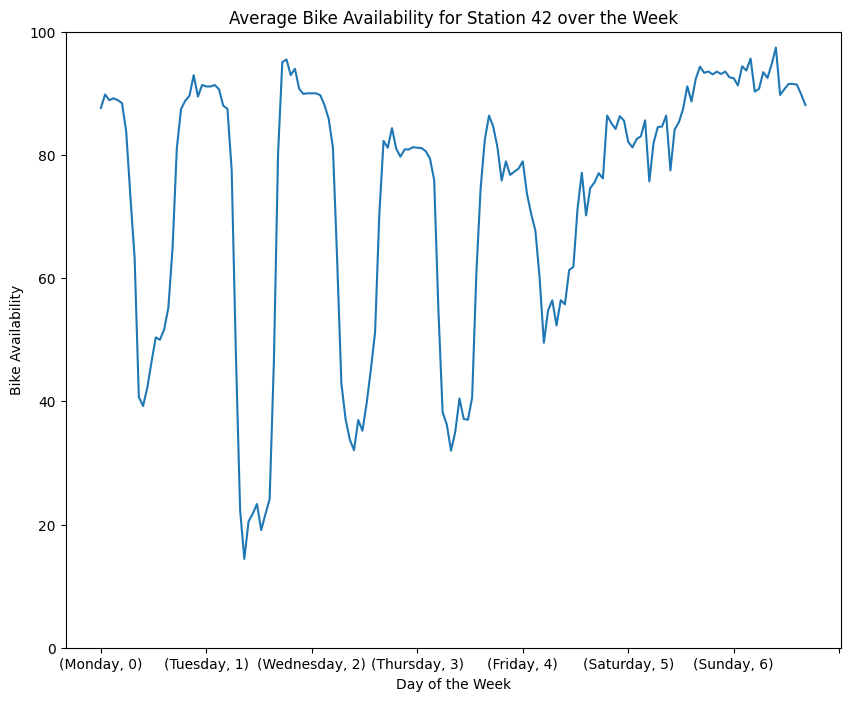

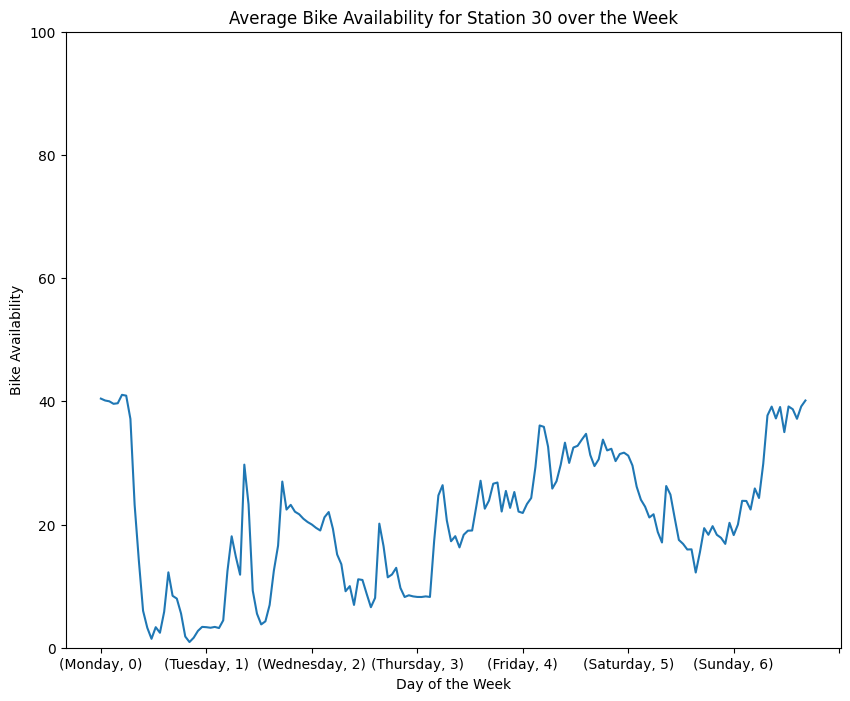

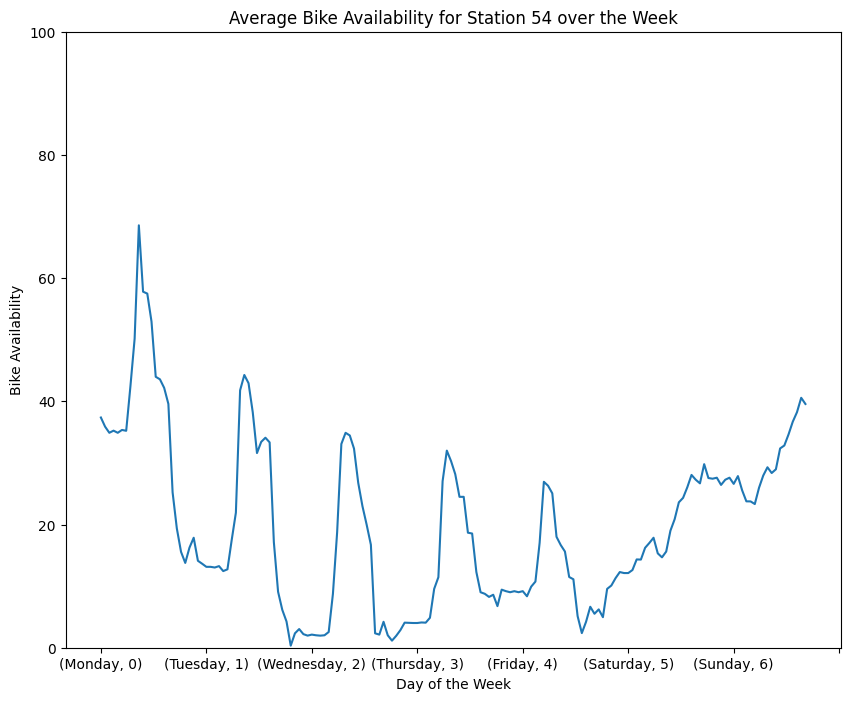

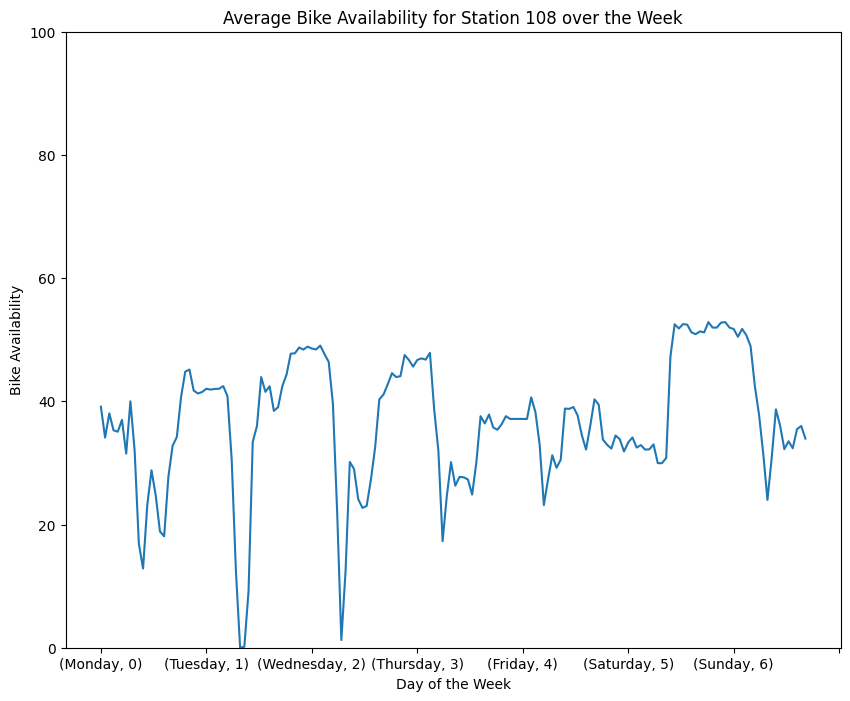

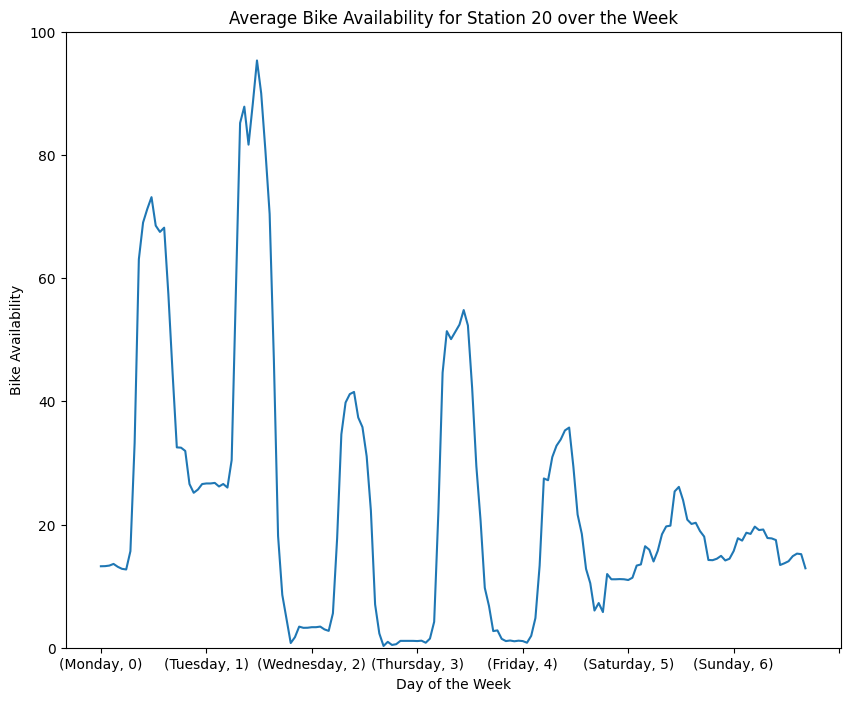

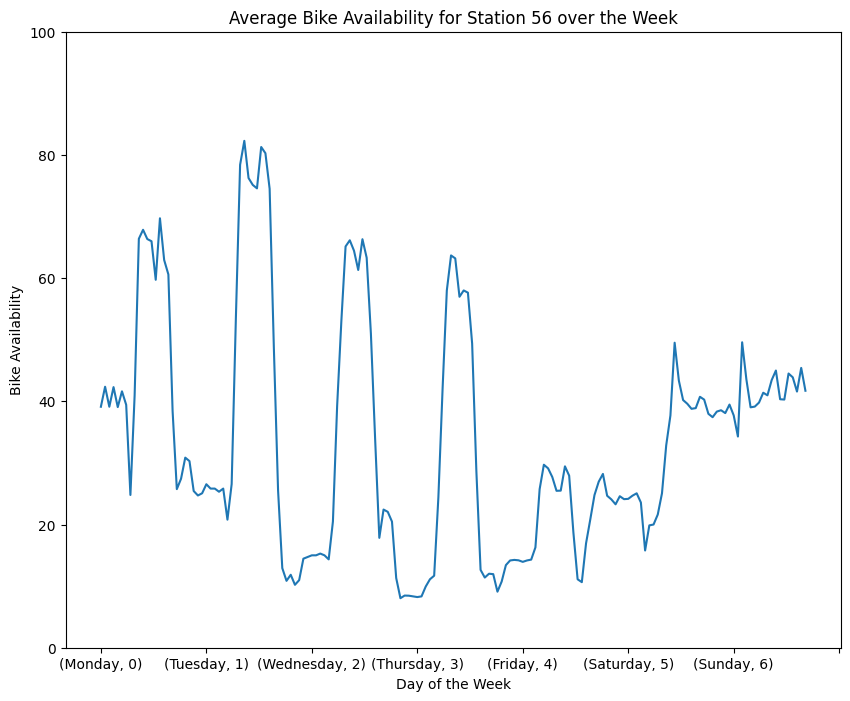

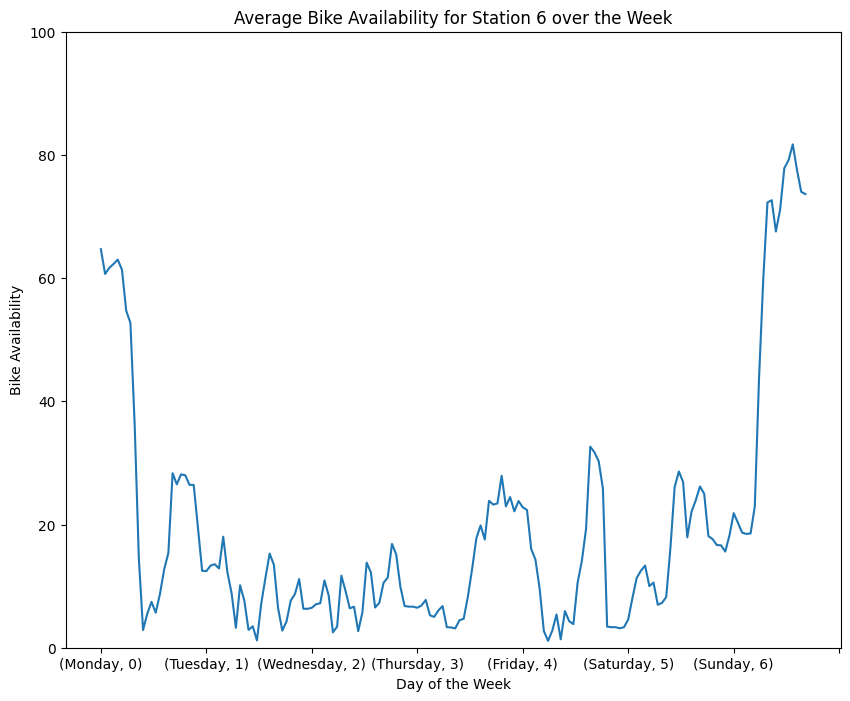

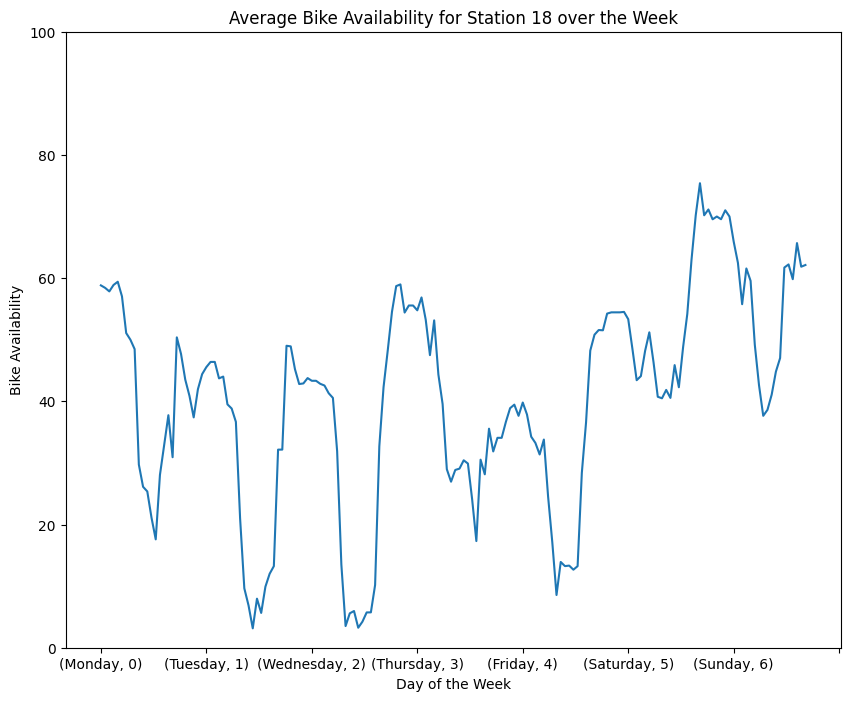

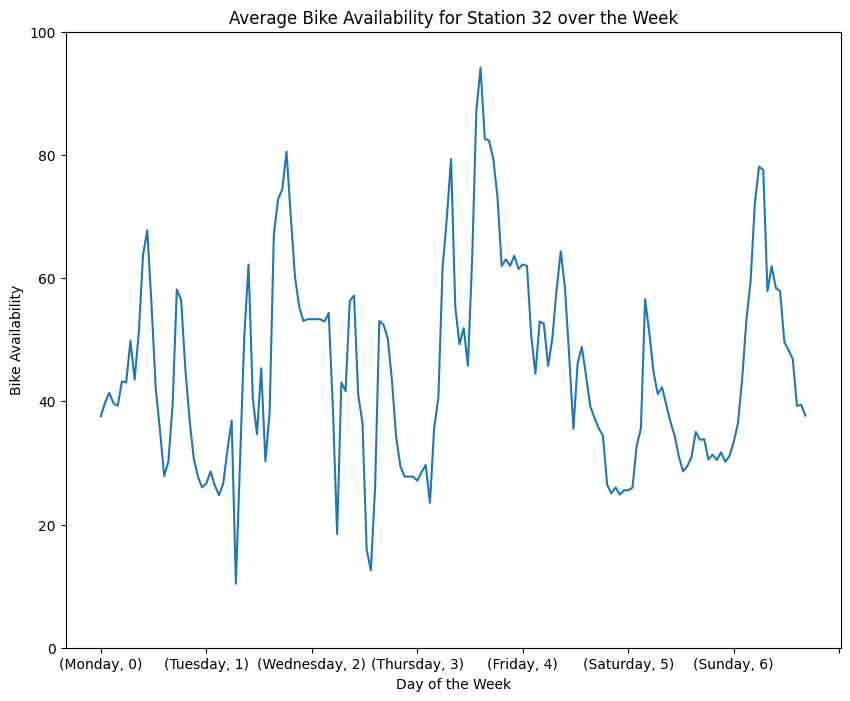

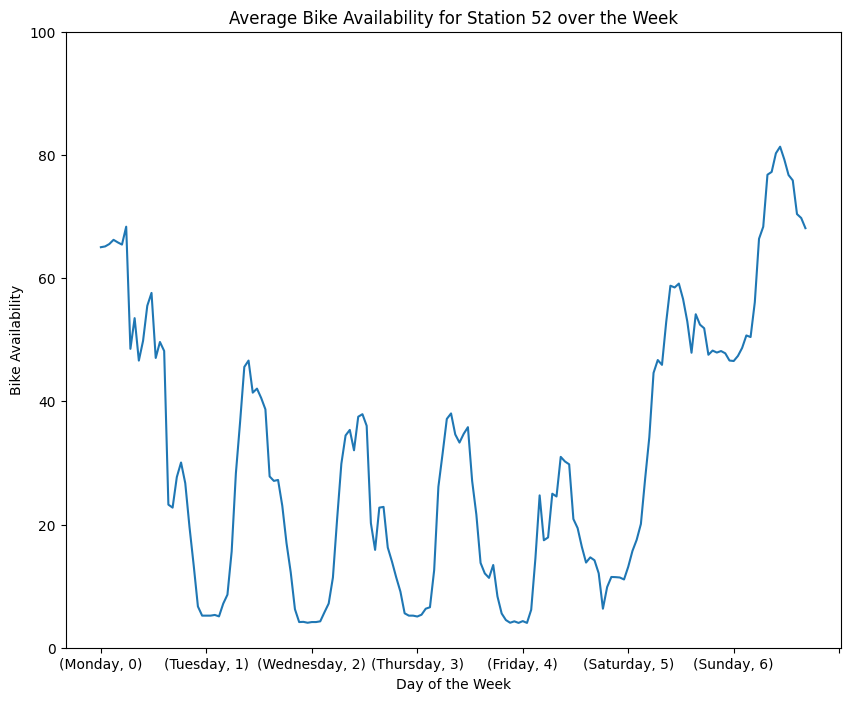

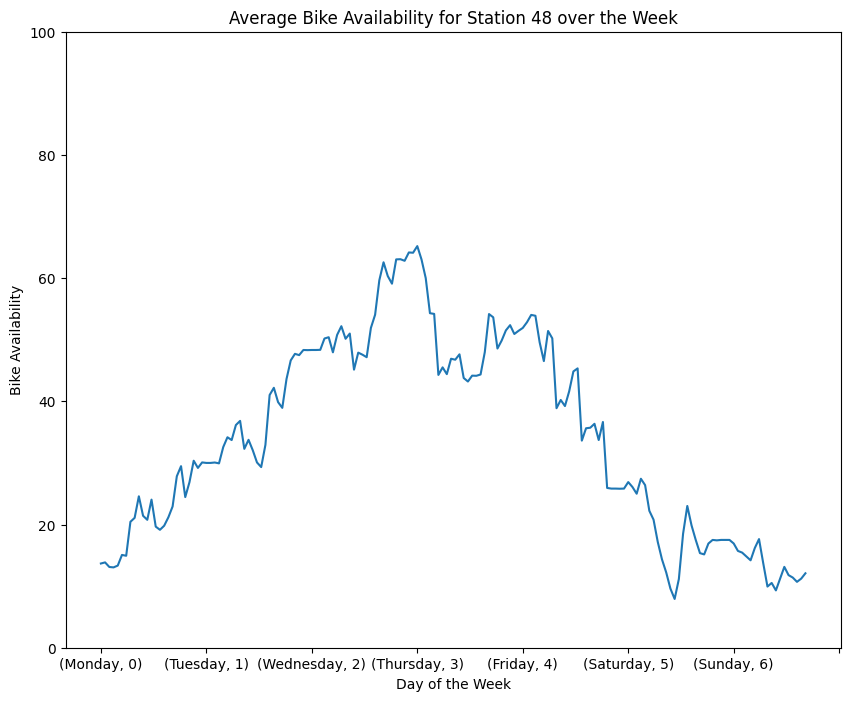

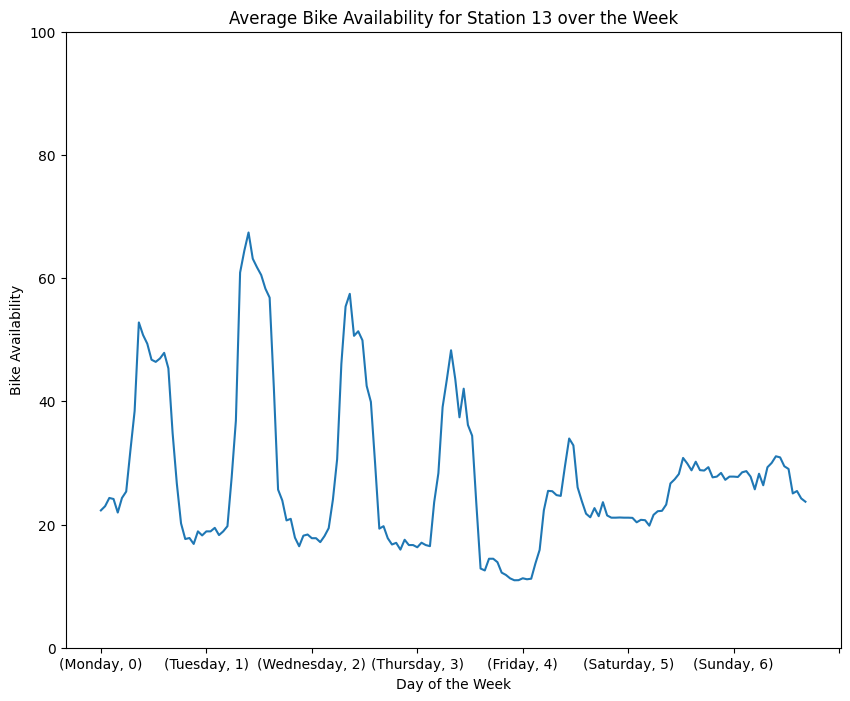

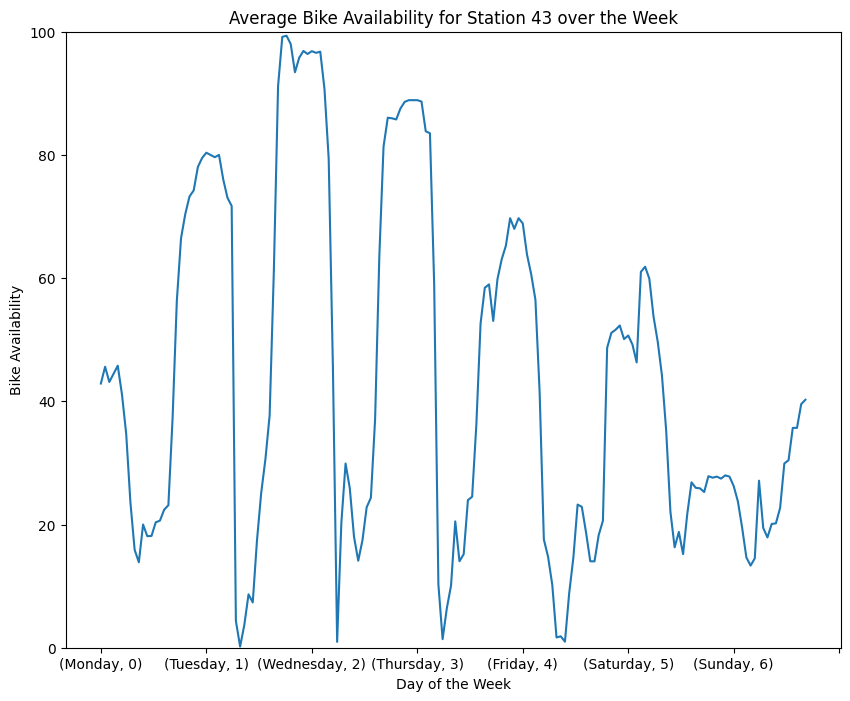

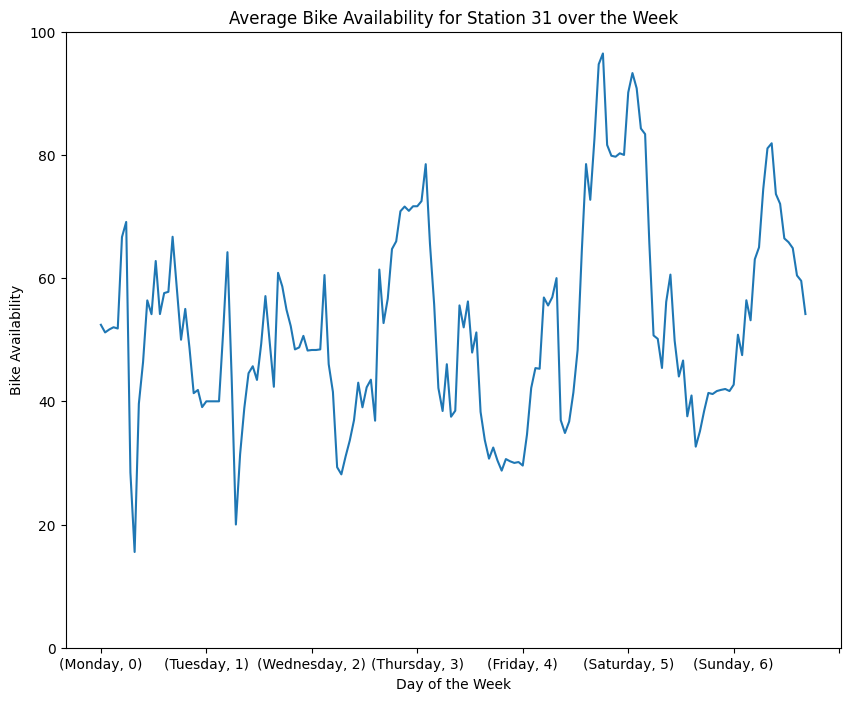

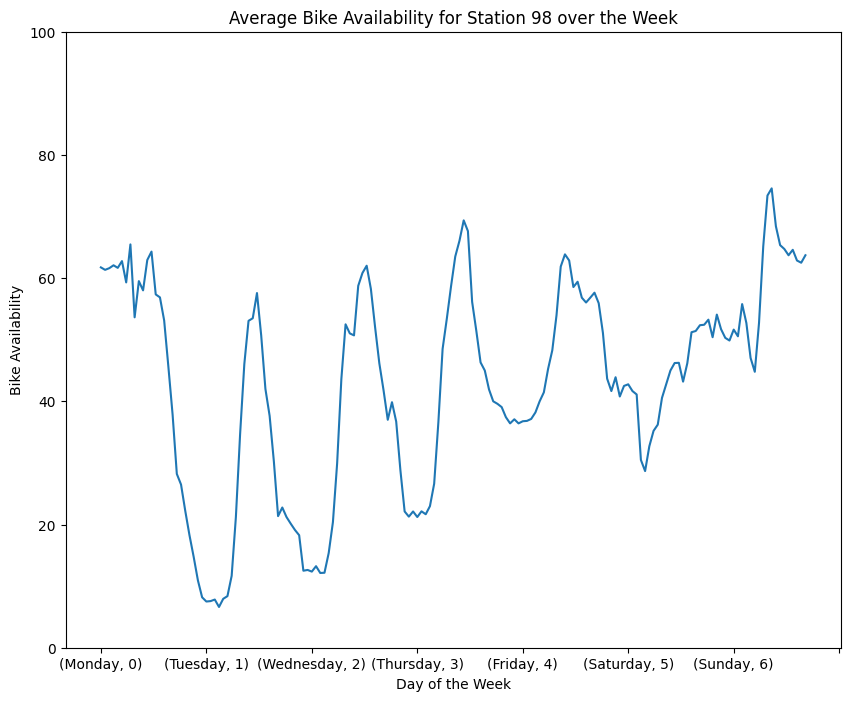

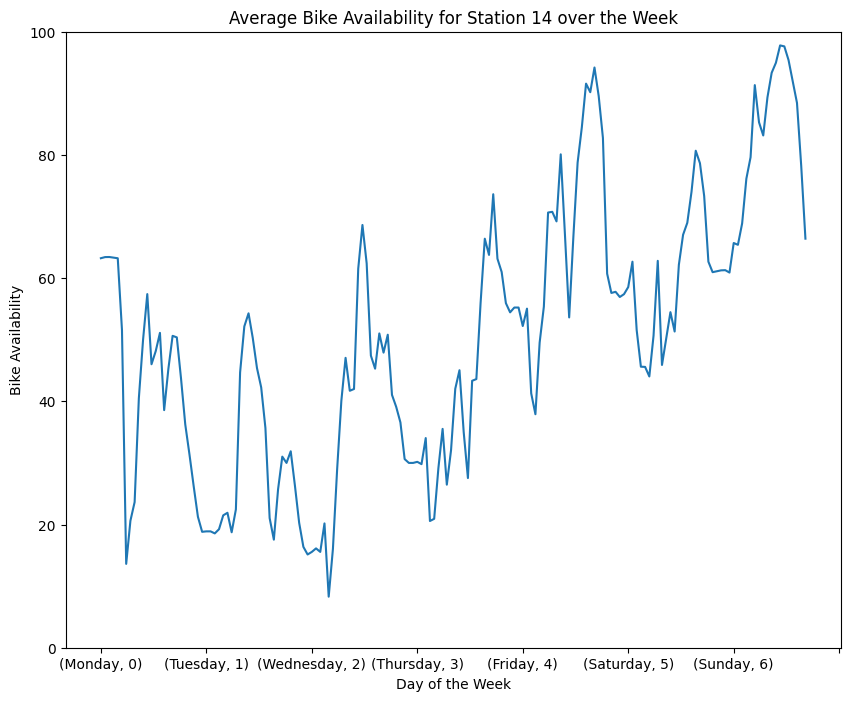

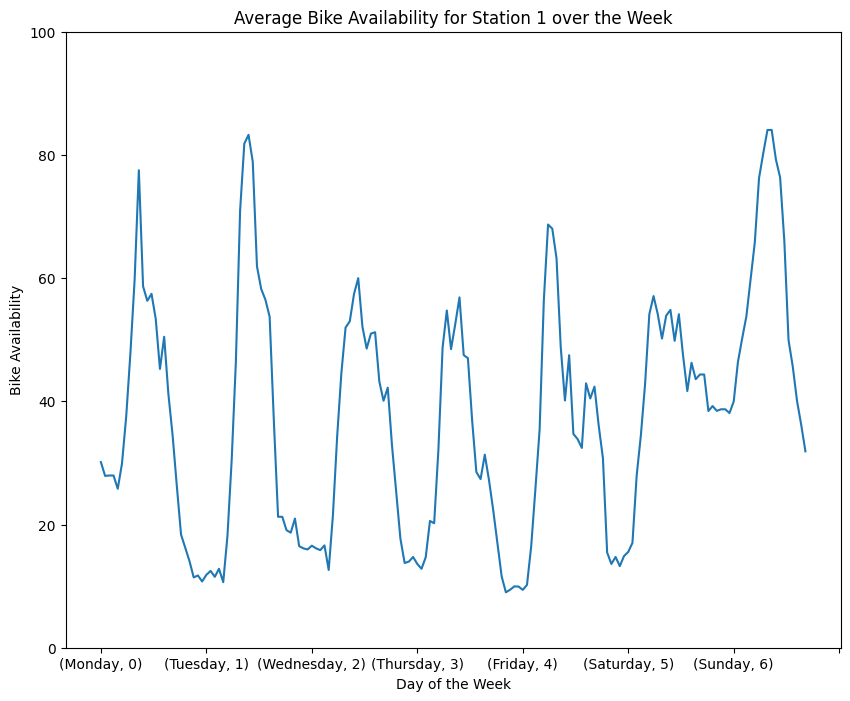

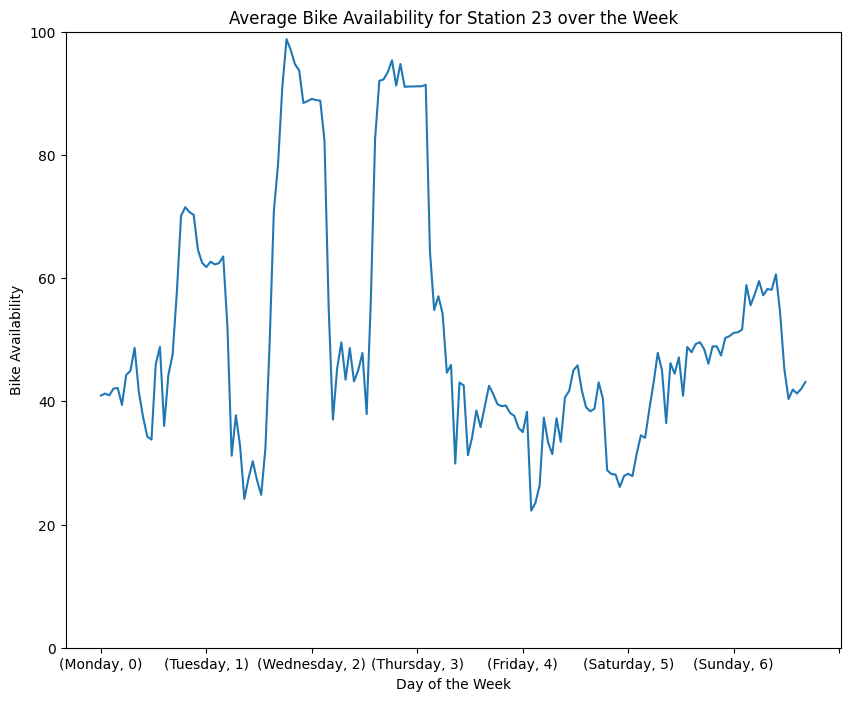

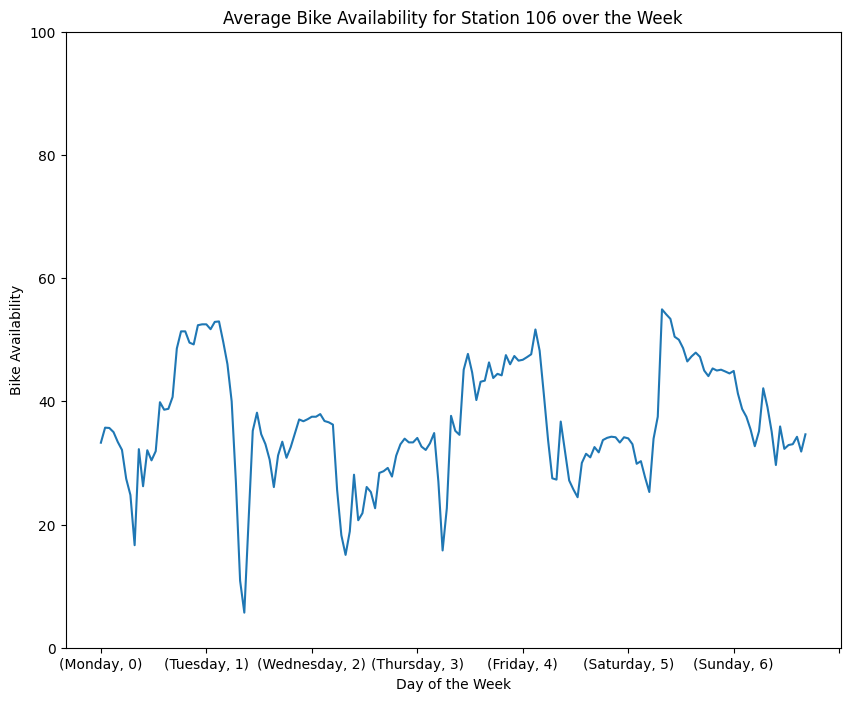

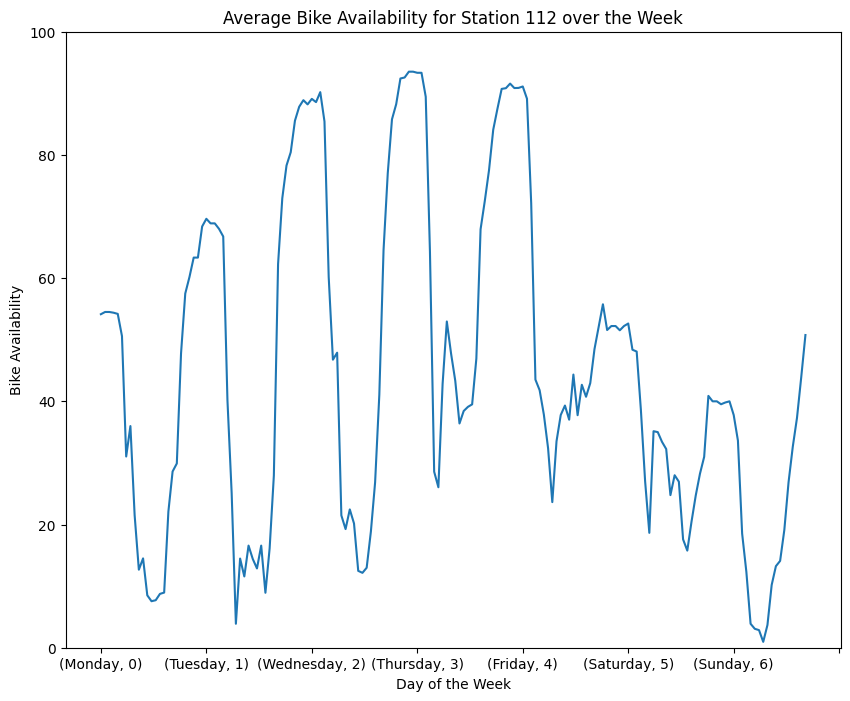

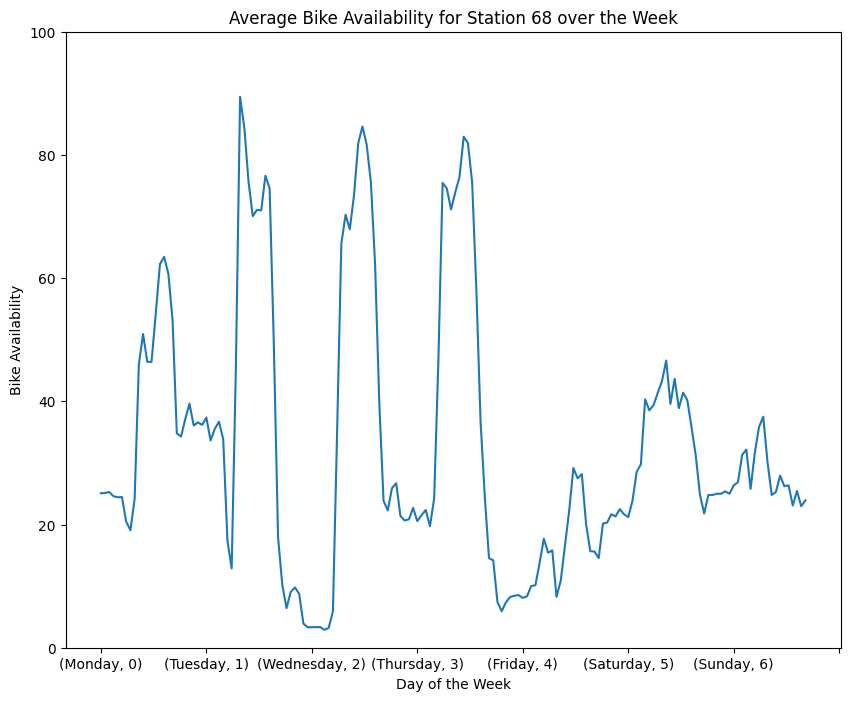

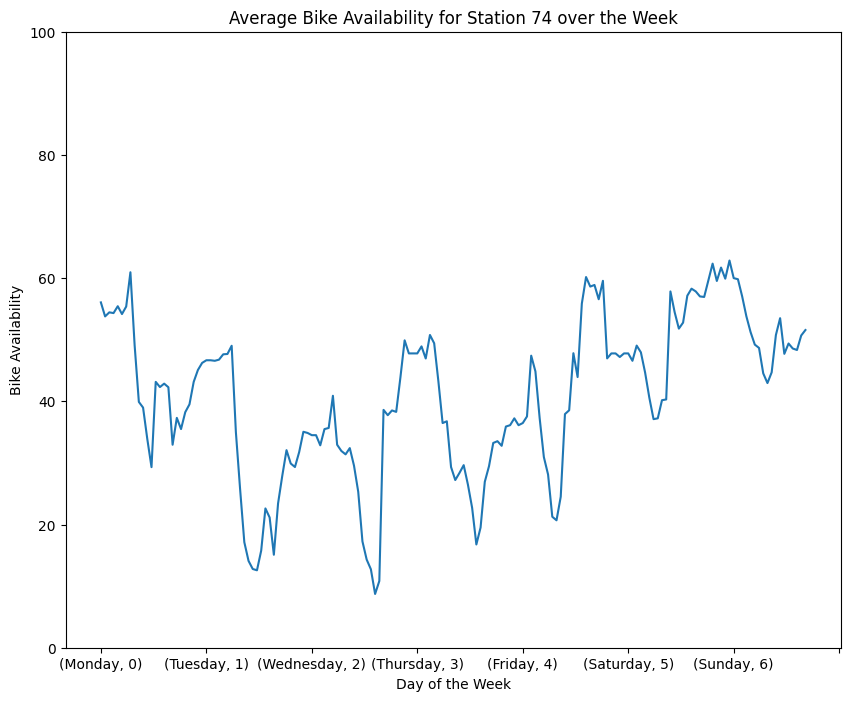

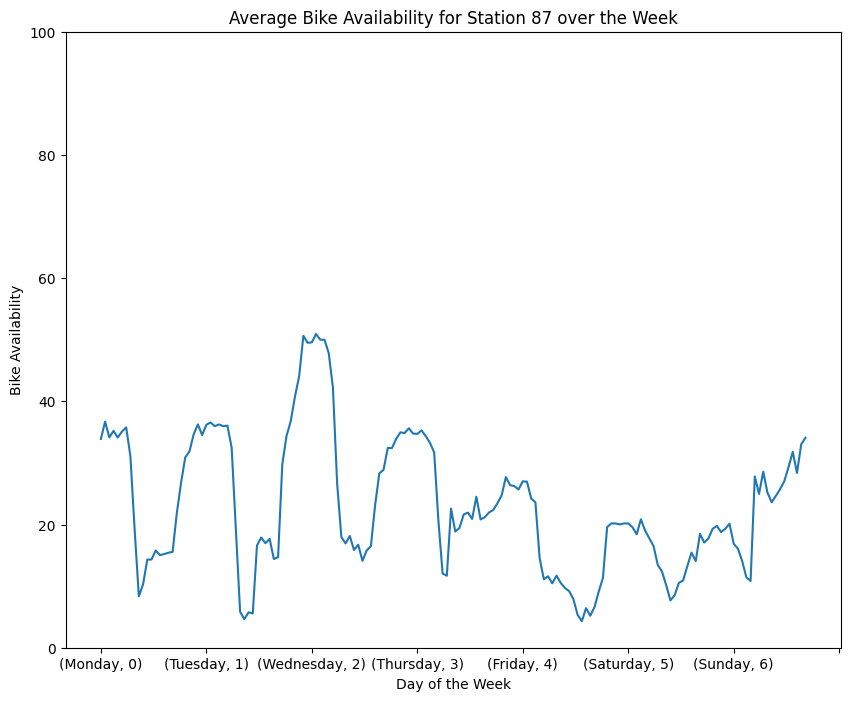

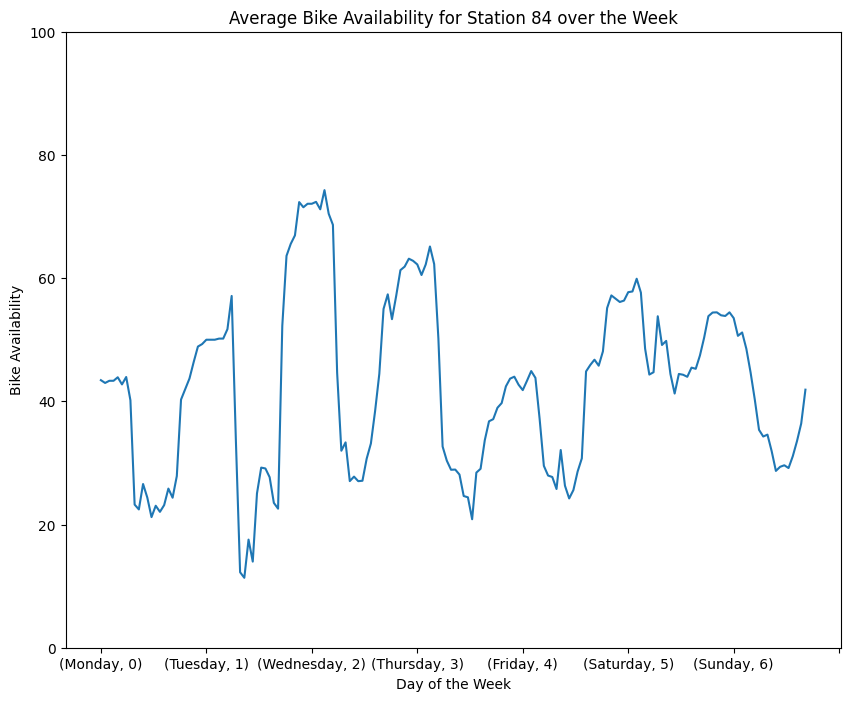

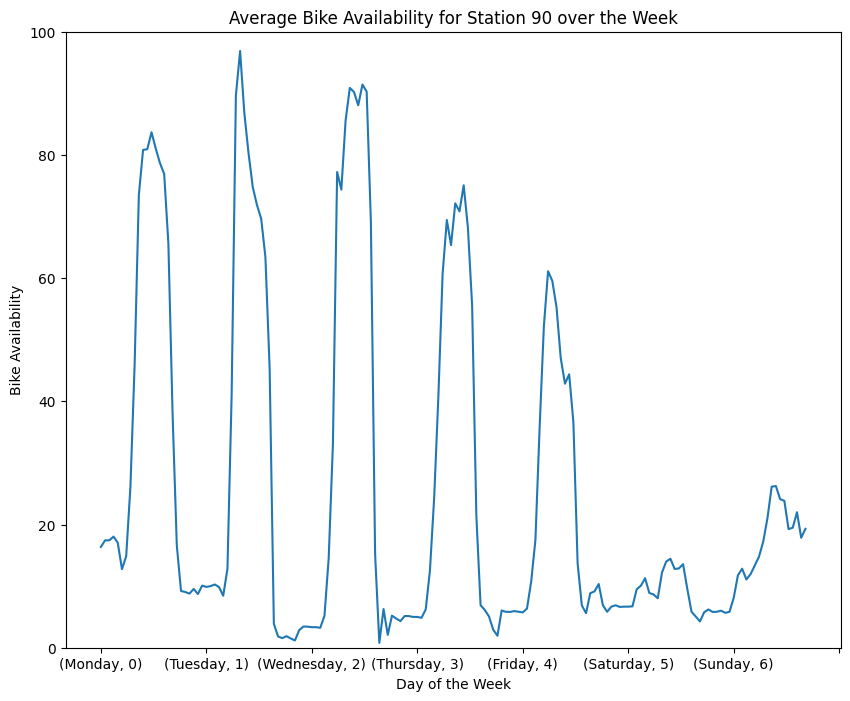

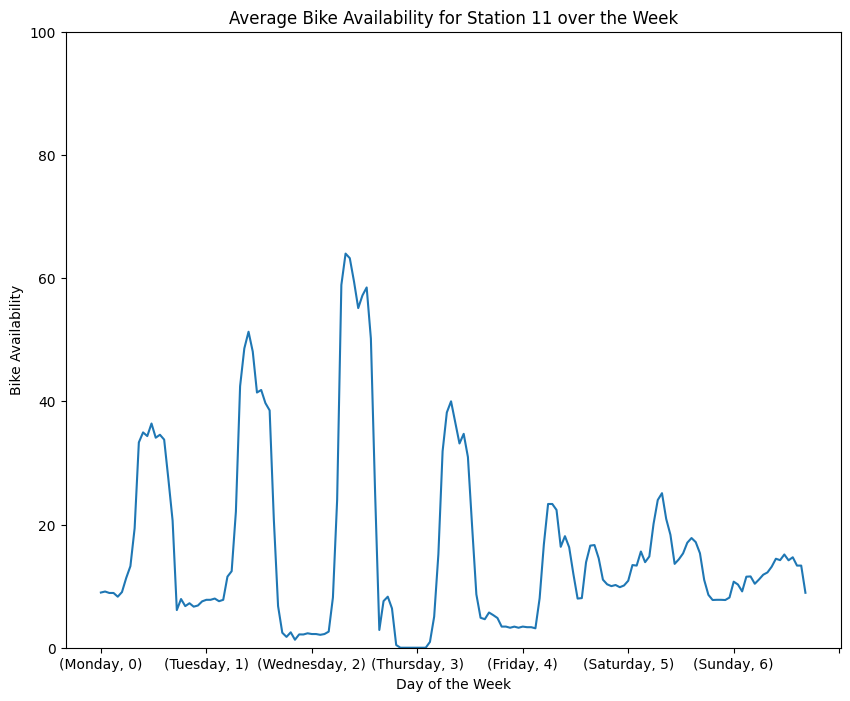

KeyboardInterrupt: 

In [762]:
#pick some stations to plot
length = len(df_static['number'])
for i in range(0, length):
    numb=df_static['number'][i]
    average_bike_availability(numb)

### Conclusion- hours is too granular need more precision?